<div style="padding:30px;margin:10;font-size:150%;text-align:left;border-radius:10px;background-color:#133a6f;color:white;)"><b><span>Dataset Introduction</span></b> </div>

The data source is about historical Bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place.

<b><span style='color:#3f75bb'>|</span> Source: https://www.kaggle.com/datasets/lykin22/drug-data</b> 

### <b><span style='color:#3F75BB'>|</span> Domain Knowledge</b>

1. **`Timestamp` [numerical] :** Start time of time window (60s window), in Unix time

2. **`Open` [numerical] :** Open price at start time window

3. **`High` [numerical] :** Low price within time window

4. **`Low` [numerical] :** Low price within time window

5. **`Close` [numerical] :** Close price at end of time window

6. **`Volume_(BTC)` [numerical] :** Volume of BTC transacted in this window

7. **`Volume_(Currency)` [numerical] :** Volume of corresponding currency transacted in this window

8. **`Weighted_Price` [numerical] :** VWAP- Volume Weighted Average Price
<br>

### <b><span style='color:#3F75BB'>|</span> Import libraries</b>

In [343]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


### <b><span style='color:#3F75BB'>|</span> Input data</b>

In [344]:
data = pd.read_csv('~/Desktop/Git-projects/Bitcoin-Prediction-with-ARIMA-Model/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="padding:30px;margin:10;font-size:150%;text-align:left;border-radius:10px;background-color:#133a6f;color:white;)"><b><span>Quality Analysis</span></b> </div>

### <b><span style='color:#3F75BB'>|</span> Data quality check - null and missing values</b>

In [345]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB
None


### <b><span style='color:#3F75BB'>|</span> Data quality check - duplicates</b>

In [346]:
duplicate_rows_data = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (0, 8)


### <b><span style='color:#3F75BB'>|</span> Data quality check - Organise the time format and include only the price column</b>

In [347]:
# Unix-time to Datetime
data['date'] = pd.to_datetime(data['Timestamp'], unit='s')

data.rename(columns={'Weighted_Price': 'price'}, inplace=True)
# create a new daafame with only the date and price columns
data = data[['date', 'price']]
data.set_index('date', inplace=True)
print(data.head())

                     price
date                      
2011-12-31 07:52:00   4.39
2011-12-31 07:53:00    NaN
2011-12-31 07:54:00    NaN
2011-12-31 07:55:00    NaN
2011-12-31 07:56:00    NaN


### <b><span style='color:#3F75BB'>|</span> Data quality check - Resample data by day</b>

In [348]:
# Resampling to monthly frequency
data = data.select_dtypes(include='number').resample('W').mean()

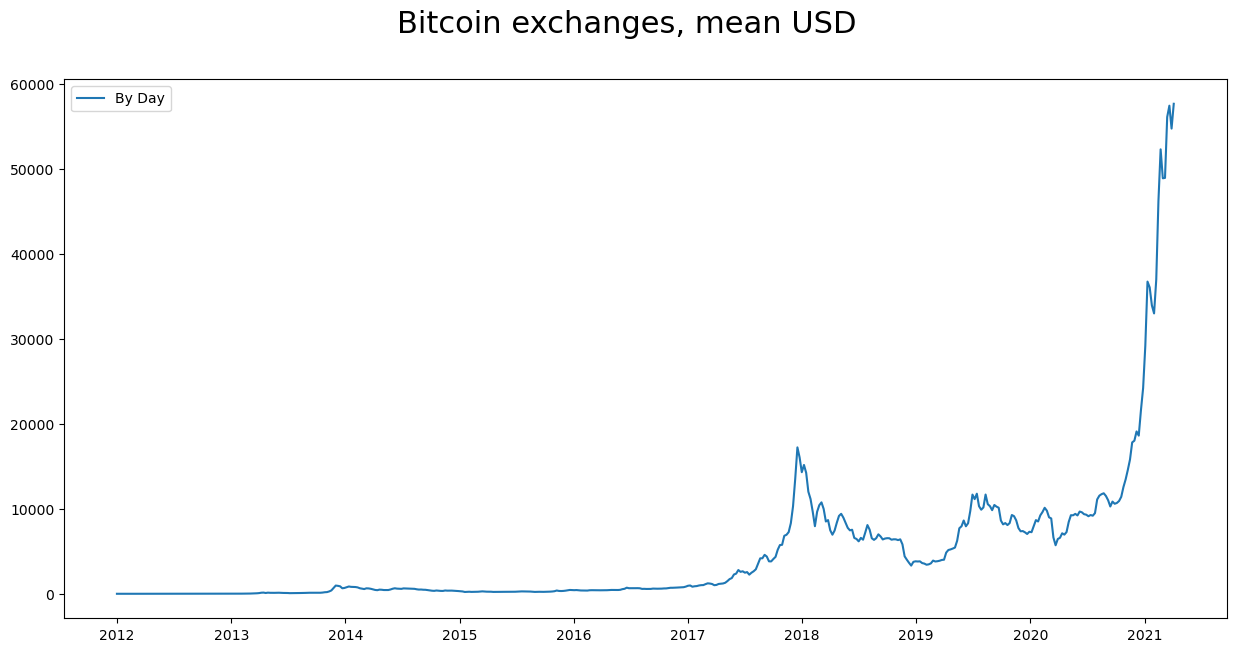

In [349]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)
plt.plot(data['price'], '-', label='By Day')
plt.legend()
plt.show()

<div style="padding:30px;margin:10;font-size:150%;text-align:left;border-radius:10px;background-color:#133a6f;color:white;)"><b><span>Dimensional Analysis</span></b> </div>


### <b><span style='color:#3F75BB'>|</span> Trend overview</b>

Text(0, 0.5, 'Price')

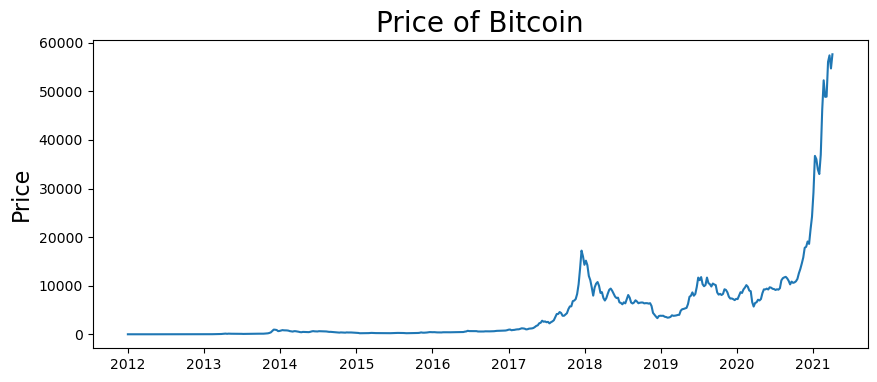

In [350]:
plt.figure(figsize=(10,4))
plt.plot(data)
plt.title('Price of Bitcoin', fontsize=20)
plt.ylabel('Price', fontsize=16)

<b><span style='color:#3F75BB'>-</span> Findings</b>
- Since the trend tend to be fluctuating after 2018, the following analysis will based on the date after 2018.

In [351]:
start_date = datetime(2018,1,1)
end_date = datetime(2021,1,1)
data = data[start_date:end_date]
print(data.head())

                   price
date                    
2018-01-07  15153.613528
2018-01-14  14232.056485
2018-01-21  12005.584040
2018-01-28  11154.755939
2018-02-04   9653.358450


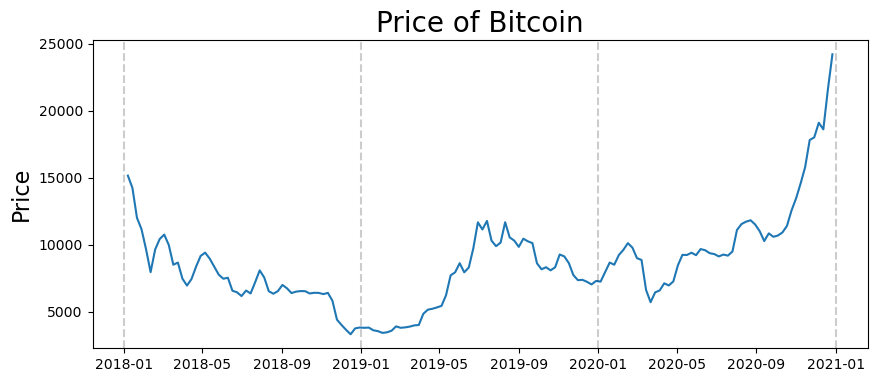

In [352]:
plt.figure(figsize=(10,4))
plt.plot(data)
plt.title('Price of Bitcoin', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### <b><span style='color:#3F75BB'>|</span> Stationary test</b>

In [353]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data['price'])[1])

Dickey–Fuller test: p=0.998083


<b><span style='color:#3F75BB'>-</span> Findings</b>
- Test the original data, the P-value is above 0.05, so it is does not prove null hypothesis.

In [354]:
# Regular differentiation
data['price_diff'] = (data['price'] - data['price'].shift(1)).dropna()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data['price_diff'][1:])[1])


Dickey–Fuller test: p=0.000025


<b><span style='color:#3F75BB'>-</span> Findings</b>
- Test the difference (1) data, the P-value is below 0.05, proves it's null hypothesis, so it is stationary.

### <b><span style='color:#3F75BB'>|</span> Seasonal analysis</b>

<Figure size 1500x700 with 0 Axes>

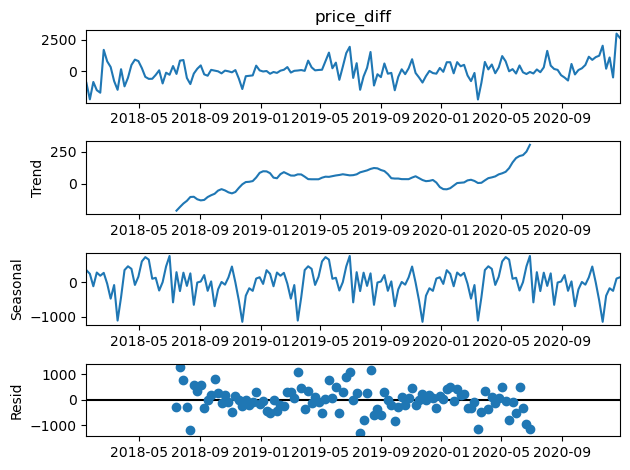

In [355]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(data['price_diff'][1:]).plot()   
plt.show()

<b><span style='color:#3F75BB'>-</span> Findings</b>
- After stationary, the decompose process shows that the series has a seasonal period of approx 1 year (12 month).

### <b><span style='color:#3F75BB'>|</span>ACF and PACF test</b>

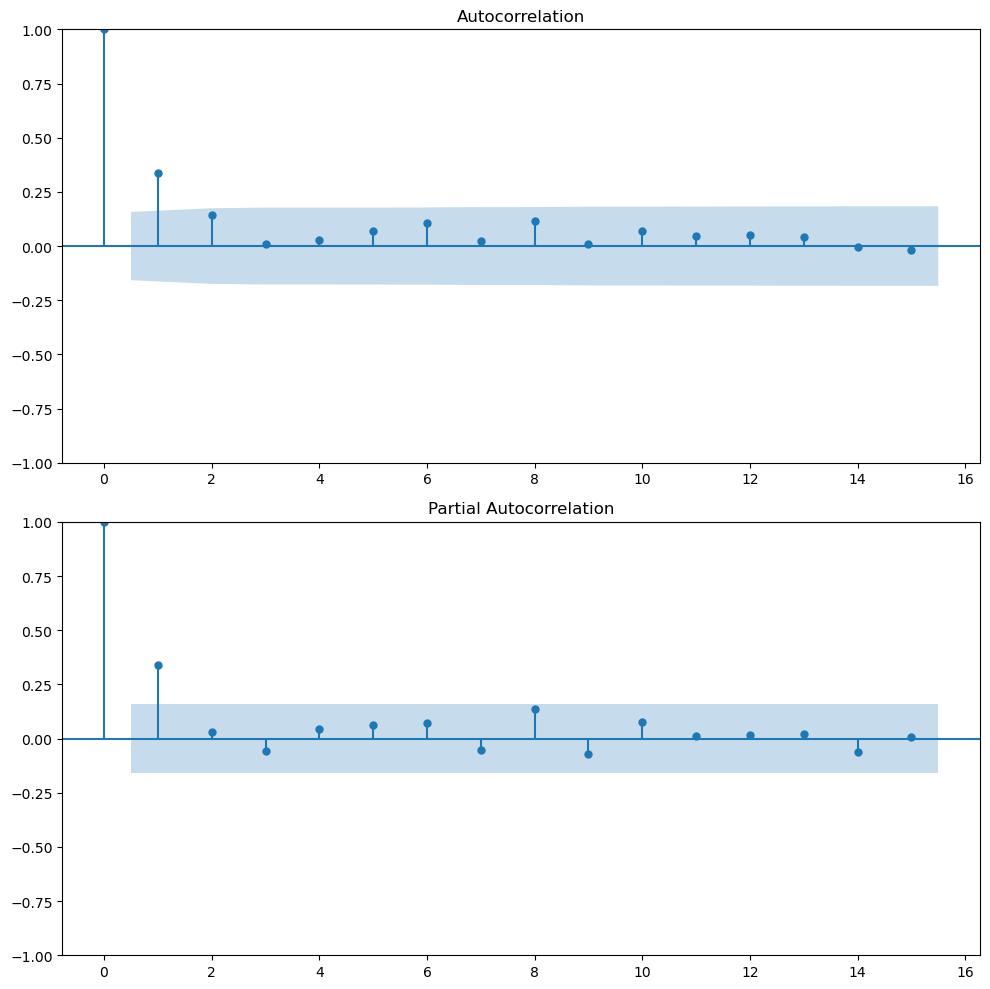

In [359]:
plt.figure(figsize=(10,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['price_diff'][1:], lags=15, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['price_diff'][1:], lags=15, ax=ax)
plt.tight_layout()
plt.show()